In [1]:
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import glob
import os
import math

os.chdir('/home/jyang4/repos/DKBO-MLDE/')
#import objectives
#import utils
from tqdm import tqdm
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
# %matplotlib notebook
import seaborn as sns

font = {'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")

/home/jyang4/miniconda3/envs/dkbo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check the log likelihood during training and compare between models
What are reasonable values for this number?

In [ ]:
#can check this by watching the terminal
#was indeed lower negative log likelihood for the DK compared to GP


### Analyze the distribution of sequences
5site libraries

/tmp/ipykernel_267850/1468672752.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_267850/1468672752.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_267850/1468672752.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

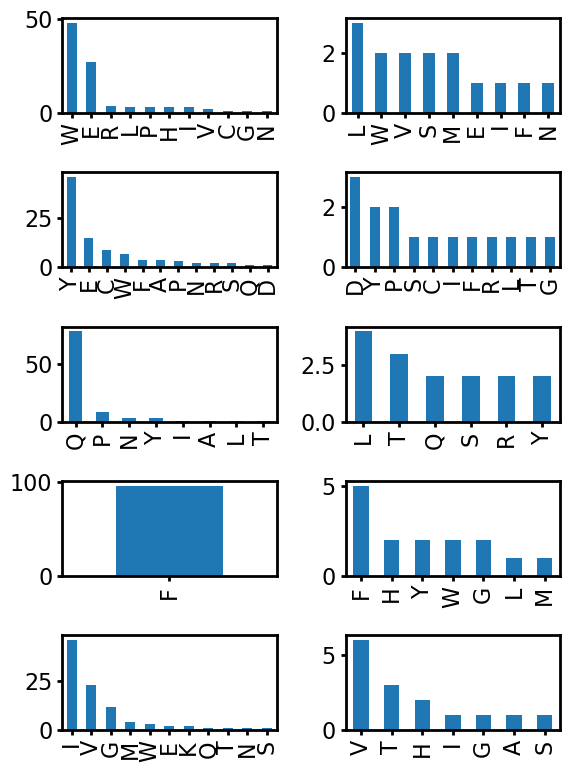

In [18]:
#just to get a mapping from indices to combos
fitness_df = pd.DataFrame()
combos = np.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/combos.npy')
fitness_df['Combo'] = combos
fitness_df

plt.figure(figsize=(6, 8))
for i in [1]:
    for j in  [0, 1]:
        if j == 0:
            # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_1indices.pt')
            indices= torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/DKL_BOTORCH-DO-0-RBF-TS-[10, 10]_1indices.pt')
            # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/GP_BOTORCH-DO-0-RBF-UCB-[100, 1]_1indices.pt')

            
            subset = fitness_df.iloc[indices, :].reset_index()
            batch = subset[-96:]
        
        #second column is the distribution of live variants
        if j == 1:
            data = pd.read_csv('/home/jyang4/repos/data/Pgb/test_fivesite.csv')
            batch = data[:15]

        n = 1
        for l in range(5):
            batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])

        for k, label  in enumerate(['AA1', 'AA2', 'AA3', 'AA4', 'AA5']):
            plt.subplot(5, 2, j + 2*k + 1)
            batch[label].value_counts().plot(kind="bar")
            #sns.countplot(x=label, data=batch)
    plt.tight_layout()

In [22]:
subset[-96:]

,index,Combo
261,2909318,WEQFI
262,3037314,WYQFI
263,637517,EYQFI
264,637527,EYQFV
265,3029314,WWQFI
...,...,...
352,637127,EYPFV
353,2733340,VCQFI
354,3005316,WSQFI
355,573519,ENQFI


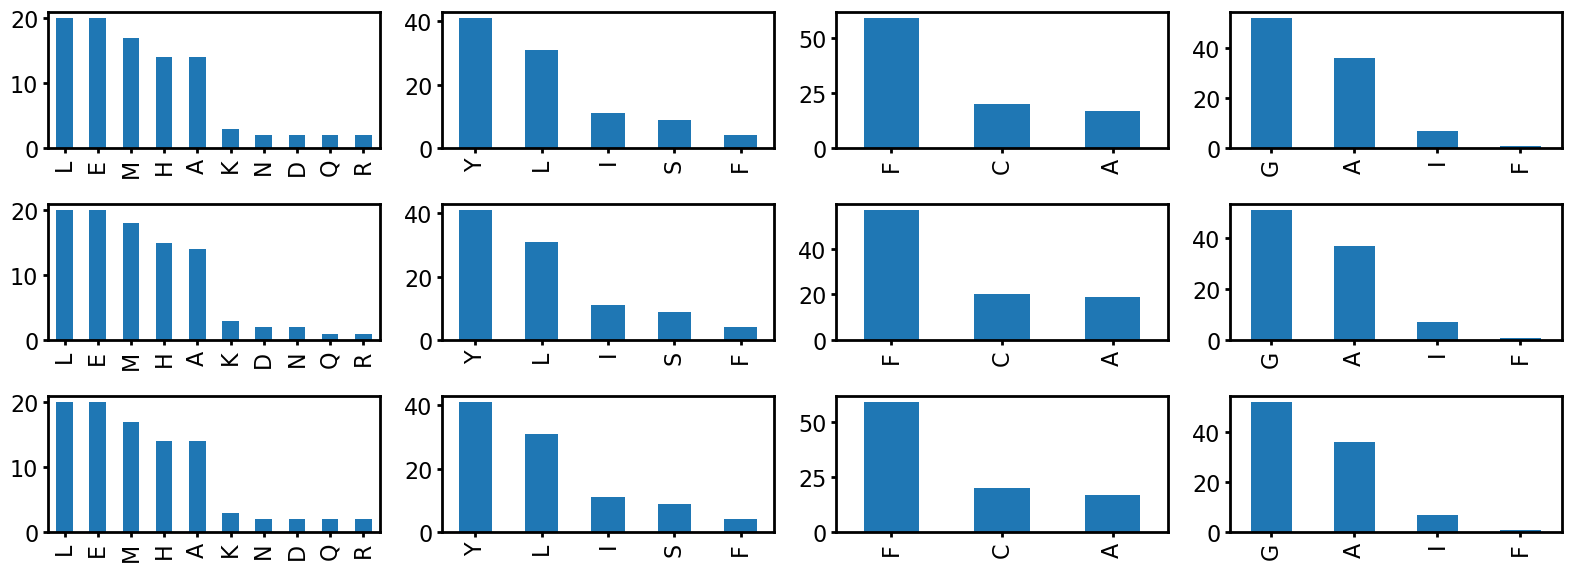

In [48]:
subdir = '/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot'
tensors = sorted(glob.glob(subdir + '/*indices*.pt'))

fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')

plt.figure(figsize=(16, 6))
for i in [2]:
    for j, acq in enumerate(['UCB', 'TS', 'GREEDY']):

        indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-%s-[10, 10]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-%s-[80, 1]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/TrpB_onehot/CDKL-DO-0-RBF-%s-[32, 32]_%dindices.pt' % (acq, i+1))

        subset = fitness_df.iloc[indices, :].reset_index()

        n = 1 #first batch after the random initialization
        batch = subset[96*n:96*(n+1)]
        for k, label  in enumerate(['AA1', 'AA2', 'AA3', 'AA4']):
            plt.subplot(3, 4, 4*j + k+1)
            batch[label].value_counts().plot(kind="bar")
            #sns.countplot(x=label, data=batch)
    plt.tight_layout()

TS proposes more diverse samples compared to UCB, especially for the GP. For DKL, the model is less pronounced

In [35]:
data = torch.load('/home/jyang4/repos/DKBO-MLDE/results/archived/trpB_onehot/DKL-DO-0-RBF-TS-[10, 10]_6indices.pt')
data.shape

torch.Size([480])

(array([ 77., 109., 158., 226., 171., 155.,  65.,  27.,   8.,   4.]),
 array([0.04903082, 0.14412774, 0.23922465, 0.33432157, 0.42941849,
        0.52451541, 0.61961233, 0.71470925, 0.80980616, 0.90490308,
        1.        ]),
 <BarContainer object of 10 artists>)

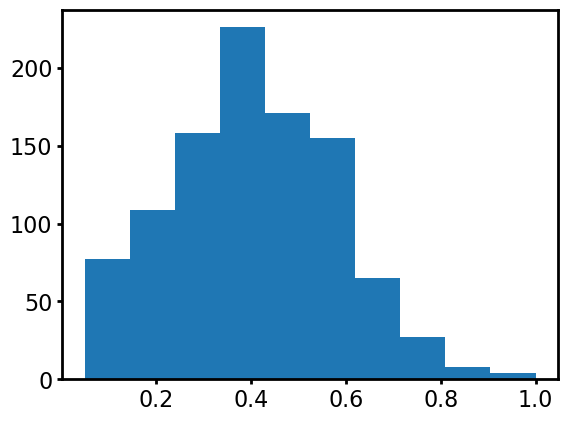

In [142]:
data = pd.read_csv('/home/jyang4/repos/data/TrpB_fitness.csv')
#randomly select 96 rows
maxes = []
for i in range(1000):
    indices = np.random.choice(data.shape[0], 96, replace=False)
    maxes.append(data['fitness'][indices].max())
plt.hist(maxes)

### Analyze the mean and uncertainty values

Maybe should only look at a subset of the values?

### Only look at the ones within 1 to 2 mutations of measured sequences

### See how close the next batch of points are in hamming distance to things that were previously sampled

In [2]:
# plt.figure(figsize=(16, 6))
# #through 10 are the third round
# #after 10 are the models from the first round
# for i in range(10):
#     # indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
#     indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')

#     #subset = fitness_df.iloc[indices[:96]]
#     subset = fitness_df.iloc[indices[:288]]
#     subset
    
#     old_combos = subset['Combo']
#     #new_combos = fitness_df.iloc[indices[96:192]]['Combo']
#     new_combos = fitness_df.iloc[indices[288:384]]['Combo']
#     min_distances = []
#     min_distances_args = []
#     for combo1 in new_combos:
#         distances = []
#         for combo2 in old_combos:
#             distances.append(sum([combo1[i] != combo2[i] for i in range(len(combo1))]))
#         min_distances.append(min(distances))
#         min_distances_args.append(np.argmin(distances))
    
#     unique_indces, counts = np.unique(min_distances_args, return_counts=True)
#     new_subset = subset.iloc[unique_indces]
#     new_subset['count'] = counts

#     # histogram of the minimum distances
#     # plt.subplot(2, 5, i+1)
#     # plt.hist(min_distances)

#     nearby_variants = []
#     for combo in subset['Combo']:
#         for site in range(4):
#             for aa in ALL_AAS:
#                 variant = combo[:site] + aa + combo[site+1:]
#                 nearby_variants.append(variant)
#     #drop duplicates in nearby_variants
#     nearby_variants = list(set(nearby_variants))

#     nearby_df = fitness_df[fitness_df['Combo'].isin(nearby_variants)]
#     nearby_indices = nearby_df.index

#     #len(nearby_variants)

# plt.tight_layout()

In [20]:
subset.sort_values('fit', ascending=False)

,Combo,muts,fit,zs score,num_muts,AA1,AA2,AA3,AA4
134973,WWFV,V39W:D40W:G41F,0.716157,129.04122,3,W,W,F,V
120359,WRFV,V39W:D40R:G41F,0.638370,118.22869,3,W,R,F,V
97671,WSFV,V39W:D40S:G41F,0.601167,127.38948,3,W,S,F,V
22915,TYGM,V39T:D40Y:V54M,0.598350,155.76928,3,T,Y,G,M
6600,LYGV,V39L:D40Y,0.579242,165.03216,2,L,Y,G,V
...,...,...,...,...,...,...,...,...,...
27772,AQFY,V39A:D40Q:G41F:V54Y,0.000000,138.10131,4,A,Q,F,Y
89606,DHAF,V39D:D40H:G41A:V54F,0.000000,147.48784,4,D,H,A,F
92093,THAN,V39T:D40H:G41A:V54N,0.000000,151.40005,4,T,H,A,N
89194,LWQQ,V39L:D40W:G41Q:V54Q,0.000000,138.38524,4,L,W,Q,Q


In [21]:
#count tells you how many times this was the closest mutant in the top 96
new_subset.sort_values('fit', ascending=False)

,Combo,muts,fit,zs score,num_muts,AA1,AA2,AA3,AA4,count
134973,WWFV,V39W:D40W:G41F,0.716157,129.04122,3,W,W,F,V,9
97671,WSFV,V39W:D40S:G41F,0.601167,127.38948,3,W,S,F,V,1
22915,TYGM,V39T:D40Y:V54M,0.598350,155.76928,3,T,Y,G,M,5
6600,LYGV,V39L:D40Y,0.579242,165.03216,2,L,Y,G,V,10
103072,WVFV,V39W:D40V:G41F,0.565280,124.88220,3,W,V,F,V,1
99020,WIFV,V39W:D40I:G41F,0.562328,127.25167,3,W,I,F,V,2
28746,WAFV,V39W:D40A:G41F,0.557065,126.61346,3,W,A,F,V,1
46375,WKFV,V39W:D40K:G41F,0.512493,124.36001,3,W,K,F,V,1
70642,WKFG,V39W:D40K:G41F:V54G,0.508239,136.72311,4,W,K,F,G,4
2351,IYGV,V39I:D40Y,0.500772,166.74903,2,I,Y,G,V,5


In [4]:
subset['fit'].max()

0.6260269025642482

### Do it all here

0.8973761557568576
0.7385997683464893
0.972529642945615
0.9712709475699814
0.5597311212431625
0.6425037325674038
0.6425372085082451
0.9569499400780659
0.8506236567778738
0.5015633264372895


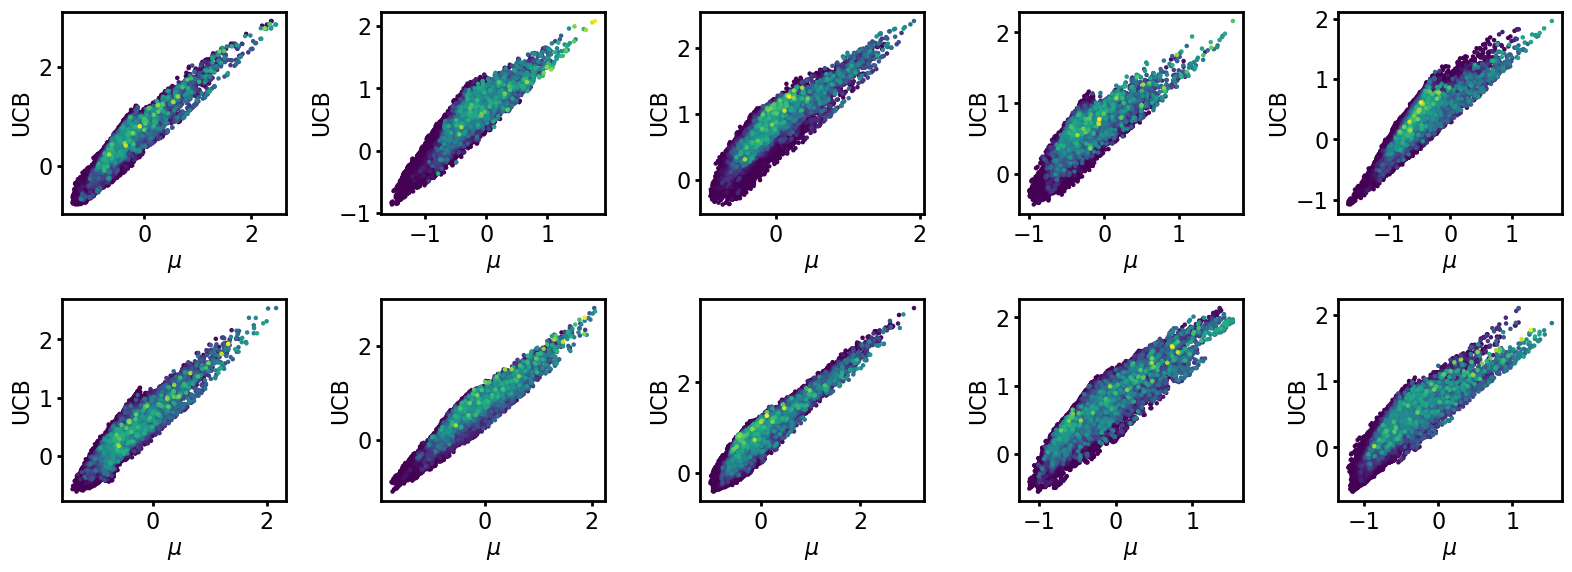

In [2]:
plt.figure(figsize=(16, 6))

protein = 'GB1'
encoding = 'AA'
model = 'GP'

for i in range(10):

    # mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
    # sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')

    if protein == 'GB1':
        fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')
        fitness_col = 'fit'
        if model == 'DKL':
            if encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}indices.pt')
            elif encoding == 'onehot':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')
            elif encoding == 'georgiev':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-dropout':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0.1-RBF-UCB-[30, 30]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0.1-RBF-UCB-[30, 30]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0.1-RBF-UCB-[30, 30]_{str(i+1)}indices.pt')
            elif encoding == 'ESM2':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/DKL_BOTORCH-DO-0-RBF-UCB-[50, 50]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/DKL_BOTORCH-DO-0-RBF-UCB-[50, 50]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/DKL_BOTORCH-DO-0-RBF-UCB-[50, 50]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-oneround':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-oneround-DO-0-RBF-UCB-[10, 10]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-oneround-DO-0-RBF-UCB-[10, 10]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-oneround-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-long':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')
        elif model == 'CDKL':
            if encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/CDKL_BOTORCH-DO-0-RBF-UCB-[16, 16]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/CDKL_BOTORCH-DO-0-RBF-UCB-[16, 16]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/CDKL_BOTORCH-DO-0-RBF-UCB-[16, 16]_{str(i+1)}indices.pt')
        elif model == 'GP':
            if encoding == 'georgiev':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}indices.pt')
            elif encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}indices.pt')
            elif encoding == 'onehot':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
            elif encoding == 'ESM2':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/GP_BOTORCH-DO-0-RBF-UCB-[5120, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/GP_BOTORCH-DO-0-RBF-UCB-[5120, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/GP_BOTORCH-DO-0-RBF-UCB-[5120, 1]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-oneround':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-long':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
    elif protein == 'TrpB':
         fitness_df = pd.read_csv('/home/jyang4/repos/data/TrpB_fitness.csv')
         fitness_col = 'fitness'
         if model == 'DKL':
            if encoding == 'onehot':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}indices.pt')
            elif encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}indices.pt')
        
         elif model == 'GP':
            if encoding == 'onehot':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
            elif encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}indices.pt')
            elif encoding == 'georgiev':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}indices.pt')
   

    fitness_df[fitness_col] = fitness_df[fitness_col]/fitness_df[fitness_col].max()
    fitness_df['sigma'] = sigma
    fitness_df['mu'] = mu
    
    fitness_df['normalized_sigma'] = abs(sigma/mu)
    fitness_df['UCB'] = fitness_df['mu'] + 2 * fitness_df['sigma']
    fitness_df['LCB'] = fitness_df['mu'] - 2 * fitness_df['sigma']
    fitness_df['calibrated'] = (fitness_df[fitness_col] > fitness_df['LCB']) & (fitness_df[fitness_col] < fitness_df['UCB'])
    fitness_df['normalized_error'] = abs((fitness_df['mu'] - fitness_df[fitness_col])/fitness_df['mu'])
    fitness_df['error'] = abs((fitness_df['mu'] - fitness_df[fitness_col]))
    
    print(fitness_df['calibrated'].sum()/len(fitness_df))

    #subset = fitness_df.iloc[indices[:96]]
    subset = fitness_df.iloc[indices[:288]]
    subset
    
    old_combos = subset['Combo']
    #new_combos = fitness_df.iloc[indices[96:192]]['Combo']
    new_combos = fitness_df.iloc[indices[288:384]]['Combo']
    min_distances = []
    min_distances_args = []
    for combo1 in new_combos:
        distances = []
        for combo2 in old_combos:
            distances.append(sum([combo1[i] != combo2[i] for i in range(len(combo1))]))
        min_distances.append(min(distances))
        min_distances_args.append(np.argmin(distances))
    
    unique_indces, counts = np.unique(min_distances_args, return_counts=True)
    #new_subset = subset.iloc[unique_indces]
    #new_subset['count'] = counts

    # histogram of the minimum distances
    # plt.subplot(2, 5, i+1)
    # plt.hist(min_distances)

    nearby_variants = []
    #for combo in subset['Combo']:
    ordered_subset = subset.sort_values(fitness_col, ascending=False)
    for combo in ordered_subset['Combo'][:]:
        for site in range(4):
            for aa in ALL_AAS:
                variant = combo[:site] + aa + combo[site+1:]
                nearby_variants.append(variant)
    #drop duplicates in nearby_variants
    nearby_variants = list(set(nearby_variants))
    #print(len(nearby_variants))

    #to filter to only nearby variants
    nearby_df = fitness_df[fitness_df['Combo'].isin(nearby_variants)]
    nearby_indices = nearby_df.index
    #print(nearby_df['calibrated'].sum()/len(nearby_df))

    top_nearby_df = nearby_df.sort_values(fitness_col, ascending=False)[:96]
    #print(top_nearby_df['calibrated'].sum()/len(top_nearby_df))
    #print('\n')

    #get rid of outliers
    #print(len(fitness_df))
    
    fitness_df.sort_values(fitness_col, ascending=True, inplace=True)

    plt.subplot(2, 5, i+1)

    # plt.hist(fitness_df['sigma'])
    # plt.title('$\sigma$')

    # plt.scatter(x = fitness_df['sigma'], y =fitness_df['mu'], c=fitness_df[fitness_col], cmap='viridis', vmin=0, vmax=1, s=5)
    # #plt.xlim([0, 3])
    # plt.xlabel('$\sigma$')
    # plt.ylabel('$\mu$')

    plt.scatter(x = fitness_df['mu'], y =fitness_df['UCB'], c=fitness_df[fitness_col], cmap='viridis', vmin=0, vmax=1, s=5)
    plt.xlabel('$\mu$')
    plt.ylabel('UCB')

    # plt.scatter(x = fitness_df['sigma'], y =fitness_df['error'], c=fitness_df[fitness_col], cmap='viridis', s=5)
    # plt.title(pearsonr(fitness_df['sigma'], fitness_df['error'])[0].round(2))
    # plt.xlabel('$\sigma$')
    # plt.ylabel('error')

    # fitness_df = fitness_df[fitness_df['normalized_sigma'] < 1]
    # plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['normalized_error'], c=fitness_df[fitness_col], cmap='viridis', s=5)
    # plt.xlim([0, 1])
    # #plt.ylim([0, 10])
    # plt.title(pearsonr(fitness_df['normalized_sigma'], fitness_df['normalized_error'])[0].round(2))
    # plt.xlabel('normalized $\sigma$')
    # plt.ylabel('normalized error')

plt.tight_layout()

### Old plots: see if uncertainty is calibrated with fitness

Is it correlated to error in the model?

Text(0, 0.5, '$\\mu$')

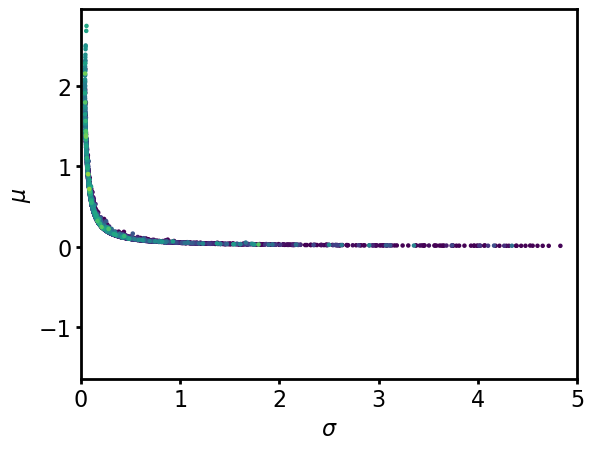

In [17]:
from scipy.stats import pearsonr

fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')

fitness_df['fit'] = fitness_df['fit']/fitness_df['fit'].max()

fitness_df['sigma'] = sigma
fitness_df['mu'] = mu
normalized = sigma/mu
fitness_df['normalized_sigma'] = normalized

fitness_df.sort_values('fit', ascending=True, inplace=True)

#sns.jointplot(fitness_df, x='sigma',  y='mu')
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['mu'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

Text(0, 0.5, 'UCB')

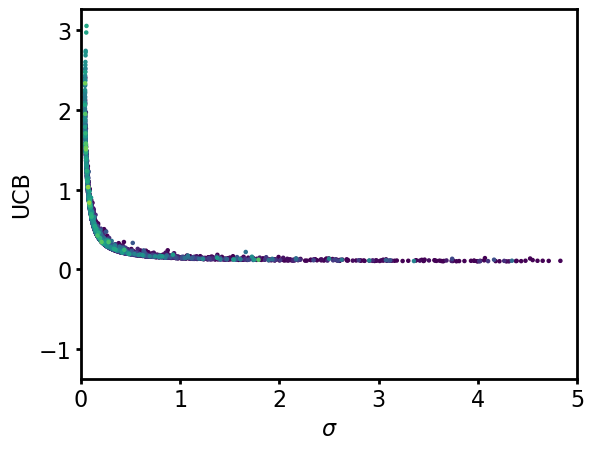

In [18]:
fitness_df['delta'] = fitness_df['mu'] + 2 * fitness_df['sigma']
#fitness_df = fitness_df.sort_values('delta', ascending=False)[:96]

#sns.jointplot(fitness_df, x = 'sigma', y = 'delta', s =2)
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['delta'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('UCB')

Text(0, 0.5, 'UCB')

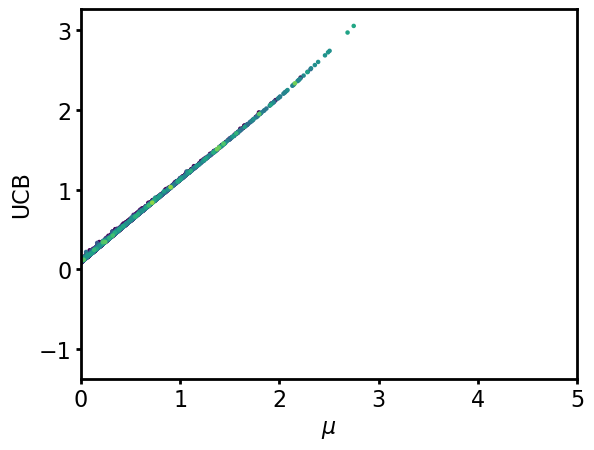

In [19]:
#sns.jointplot(fitness_df, x = 'sigma', y = 'delta', s =2)
plt.scatter(x = fitness_df['mu'], y =fitness_df['delta'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\mu$')
plt.ylabel('UCB')

PearsonRResult(statistic=-0.00015449940596186208, pvalue=0.9523871856006372)


Text(0, 0.5, 'error')

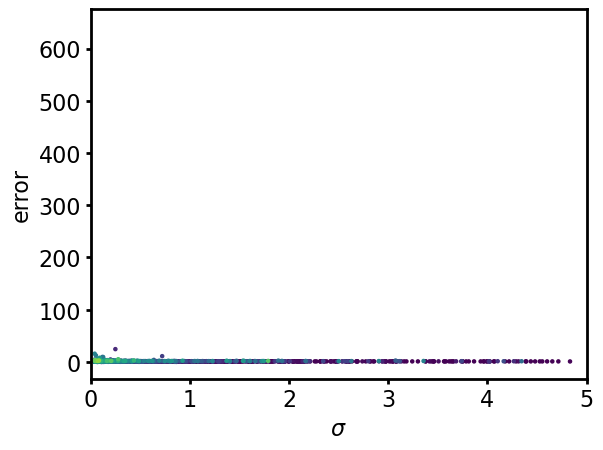

In [20]:
fitness_df['error'] = abs((mu - fitness_df['fit'])/mu)

#fitness_df['error'] = abs((fitness_df['mu'] - fitness_df['fit']))
print(pearsonr(fitness_df['normalized_sigma'], fitness_df['error']))

#sns.jointplot(fitness_df, x = 'sigma', y = 'error', s =2)
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['error'], c=fitness_df['fit'], cmap='viridis', s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('error')

### Analyze whether there is mode collapse

In [24]:
embeddings = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/embeddings.pt') # onehot, DKL, TS
#embeddings = torch.load('/home/jyang4/repos/data/trpB_onehot_x.pt')
fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')
embeddings = embeddings.detach().numpy()
embeddings.shape

(149361, 10)

In [25]:
# check for duplicates, i don't think there should be any
# for row in embeddings:
#     if len(np.where((embeddings == row).all(axis=1))[0]) > 1:
#         print('bad')

<Figure size 1200x800 with 0 Axes>

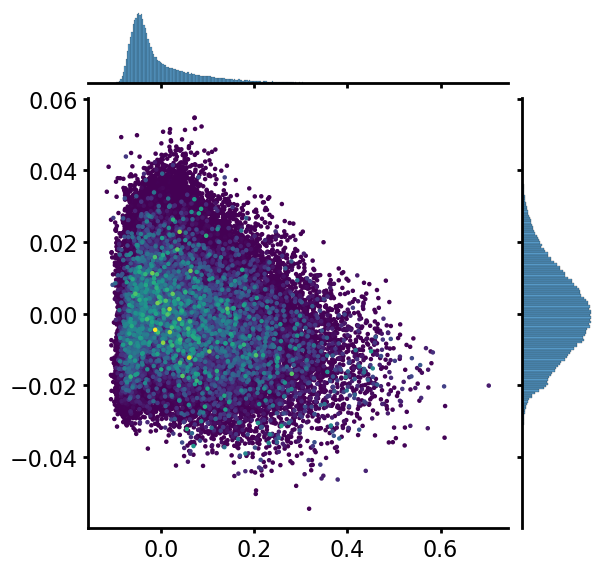

In [26]:
#PCA transform on embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)

#plot the embeddings
plt.figure(figsize=(12, 8))
fitness = fitness_df['fit'].values
#reorder the embeddings so they are based on fitness
indices = np.argsort(fitness)
sorted_fitness = fitness[indices]

sns.jointplot(x=pca_embeddings[indices, 0], y=pca_embeddings[indices, 1],s = 2)
plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], c=sorted_fitness, cmap='viridis', s=5)